# `Challenge Deep Learning`

## `Consigne`

L'objectif de ce challenge est de proposer une méthode de classification, basée sur des réseaux de neurones, permettant de classer des images de champignons.
Le jeu de données proposé comprend 3 classes balancées

Vous pouvez utiliser tout algorithme qui vous semble pertinent (PMC, CNN,), en faisant varier les données d'entrée (normalisation, augmentation de données,...), les paramètres des réseaux considérés (fonction objectif, optimiseur, dropout, learning rate, taille des batchs...)

Vous devez prendre en compte la spécificité des données (peu d'exemples, images de tailles différentes,...) pour construire vos jeux d'apprentissage et de test.

Bien sûr, pour valider votre travail, nous ferons tourner le code en local, sur une base que nous conservons, pour voir si les résultats que vous proposez sont reproductibles.

Le compte-rendu sera effectué sur un notebook jupyter, dans lequel vous reporterez votre méthodologie en markdown, et vos codes en Python. Vous **expliquerez votre démarche**, **justifierez vos choix**, **commenterez vos expérimentations et vos résultats**.

La notation sera construite de la manière suivante :
- 12 points sur le compte-rendu
- 8 points seront accordés sur un classement par le taux de reconnsaissance des objets de la base de test.

Le notebook sera déposé sur la plateforme moodle du cours.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Keras
from keras.applications import EfficientNetB0
from keras.layers import Dense, GlobalAveragePooling2D
from keras_tuner import  RandomSearch

KeyboardInterrupt: 

In [2]:
# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.applications import ResNet50,DenseNet121
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Pandas
import pandas as pd

# ``Travail``

## ``Choix des modèles``


![model](img/model.png)

## `Pré-traitement des données`


Dans un premier temps, nous allons préparer les données à l'entraînement.

Nous parcourons la structure des répertoires pour identifier les images des champignons (amanita, crimini, oyster) à récupérer pour notre dataset.

In [3]:
import pathlib

path = "datasets/mushrooms"
dset_dir = pathlib.Path(path)
image_count = len(list(dset_dir.glob('*/*.jpg')))
print(f"Nombre d'images : {image_count}")

Nombre d'images : 1644


Cela nous permet de vérifier l'intégralité du dataset et d'évaluer la taille totale des données disponibles ainsi que leur classes.

In [4]:
batch_size = 16
img_height = 224
img_width  = 224

seed = 4785

Nous procédons ensuite à la division du dataset en ensemble d' (``train_dset``), de validation (``val_dset``), et de tests (plus loin dans le rapport : ``test_dset``) pour entrâiner le réseau de neurone.

In [5]:
train_dset = tf.keras.utils.image_dataset_from_directory(
    dset_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle=True,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 1647 files belonging to 3 classes.
Using 1318 files for training.


In [6]:
val_dset = tf.keras.utils.image_dataset_from_directory(
    dset_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle=True,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 1647 files belonging to 3 classes.
Using 329 files for validation.


In [7]:
class_names = train_dset.class_names
print(class_names)

['amanita', 'crimini', 'oyster']


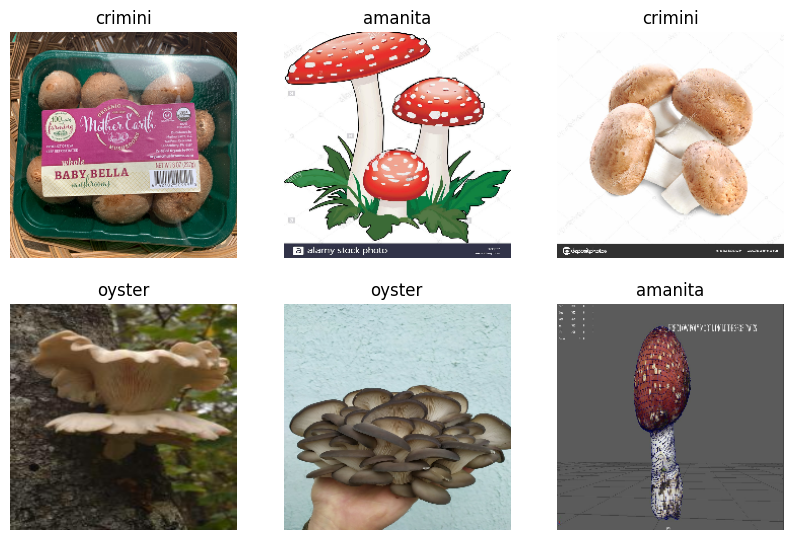

In [8]:
plt.figure(figsize=(10,10))
for images, labels in train_dset.take(1):
    for i in range(6):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# `Modèle de réseaux de neurones`


## ``ResNet50``
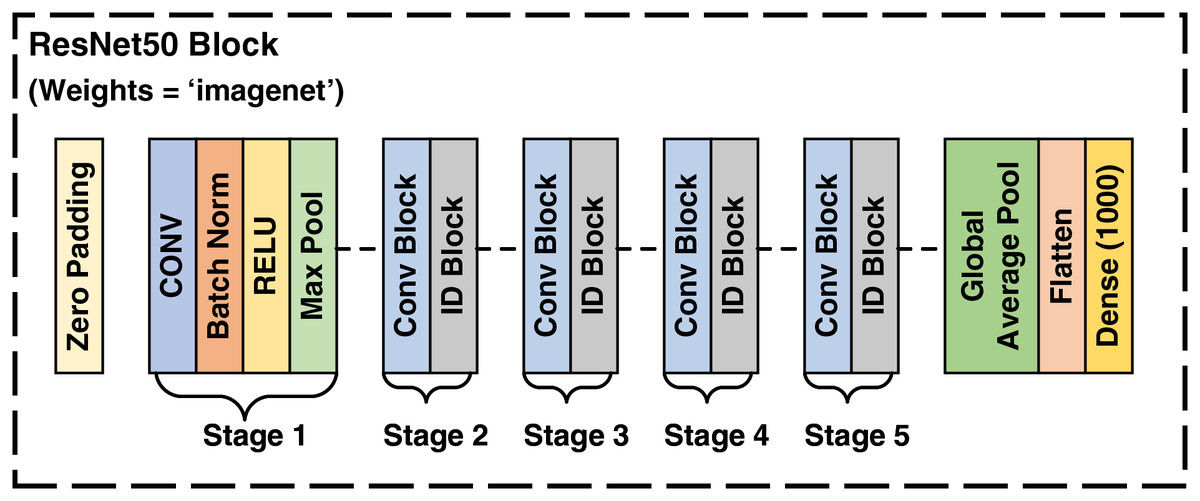

ResNet50 (Residual Network avec 50 couches) est un modèle de réseau de neurones profond.

Il fait partie de la famille des architectures ResNet, introduites par Kaiming He et al. en 2015.

L'une des caractéristiques clés de ResNet est l'utilisation de connexions résiduelles (ou skip connections), qui permettent aux gradients de se propager plus efficacement à travers le réseau en évitant le problème de vanishing gradient.

ResNet50 est composé de 50 couches de profondeur, incluant des convolutions, des couches de normalisation et des fonctions d'activation, avec des blocs résiduels pour améliorer la capacité d'apprentissage.

``Pourquoi ce choix ?``

ResNet50 est un modèle éprouvé qui a remporté des compétitions comme ImageNet en raison de sa capacité à capturer des caractéristiques complexes dans les images.

Ainsi, ce modèle peut être initialisé avec des poids pré-entraînés sur ImageNet, une large base de données d'images. Cela permet un transfert d'apprentissage, c'est-à-dire de réutiliser des caractéristiques générales d'extraction d'images (textures, contours, couleurs) pour accélérer et améliorer les performances lors de l'entraînement sur un dataset spécifique comme celui des champignons.

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dset = train_dset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dset = val_dset.cache().prefetch(buffer_size=AUTOTUNE)

print(train_dset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


La constante ``AUTOTUNE`` permet à TensorFlow d'optimiser automatiquement le chargement des données en fonction des ressources système disponibles.

Pour le jeu d'entraînement, on stocke les données en mémoire pour accélérer les itérations suivantes via le cache. Un shuffle permet de mélanger les échantillons pour éviter un surapprentissage dû à l'ordre des données, et ``.prefetch(buffer_size=AUTOTUNE)`` charge les données en parallèle au traitement pour réduire la latence.

In [10]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_dset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.003288875 0.7457207


Les données d'entrée du réseau de neurones sont correctement normalisées.

La normalisation améliore la stabilité de l'optimisation et accélère la convergence du modèle.

#### ``Augmentation du jeu de données``

L'augmentation de données est essentielle dans les tâches de vision par ordinateur, surtout lorsque le dataset est limité.

In [11]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.3)
])

C:\Users\reynalde\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Ce code permet ici de générer de nouvelles images à partir de l'ensemble existant en appliquant des transformations (rotation, zoom, flip horizontal & vertical) à l'ensemble de données.

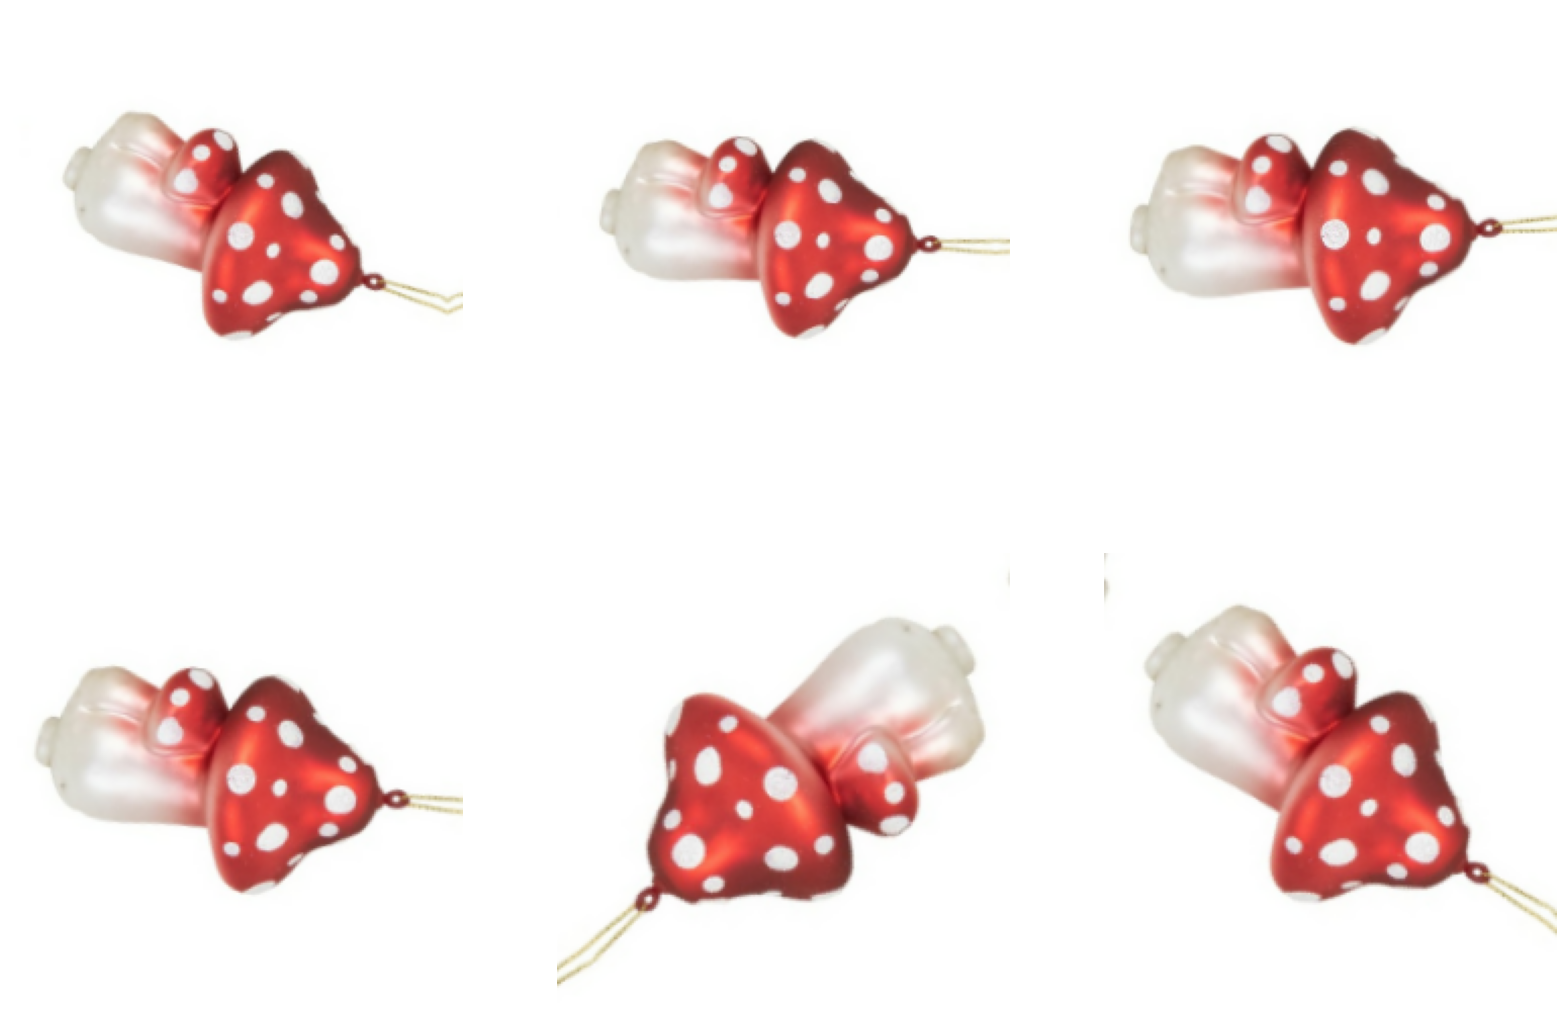

In [12]:
plt.figure(figsize=(20,20))
for images, _ in train_dset.take(1):
    for i in range(6):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### ``Implémentation du modèle``

In [13]:
from keras.src.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast

# Nombre de classes dans le dataset (ici : 3)
num_classes = len(class_names)

# Augmentation du jeu de données
data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width, 3)),  # Retournement aléatoire horizontal et vertical
    RandomRotation(0.5),  # Rotation aléatoire jusqu'à 50% d'un tour
    RandomZoom(0.5),  # Zoom aléatoire jusqu'à 50%
    RandomContrast(0.5)  # Variation aléatoire du contraste jusqu'à 50%
])

# Modèle ResNet50 pré-entraîné avec les poids d'ImageNet, sans les couches de sortie (include_top=False)
resnet_model = ResNet50(weights="imagenet", include_top=False)

for layer in resnet_model.layers[:100]:
    layer.trainable = False

# Définition du modèle final avec les étapes suivantes :
model = Sequential([
    data_augmentation,
    resnet_model,
    GlobalAveragePooling2D(),
    Dense(128, activation="relu"),
    Dense(num_classes, activation="softmax")
])

# Compilation du modèle avec :
# - Optimiseur "adam" pour un apprentissage efficace
# - Fonction de perte "sparse_categorical_crossentropy"
# - Mesure de précision comme métrique d'évaluation
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,371 (90.98 MB)

 Trainable params: 19,715,587 (75.21 MB)

 Non-trainable params: 4,134,784 (15.77 MB)

In [15]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("Model(ResNet50).h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto', save_freq="epoch")
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,
                              mode='max', cooldown=2, patience=3, min_lr=0)


In [16]:
epochs = 15

history = model.fit(
    train_dset,
    validation_data=val_dset,
    epochs=epochs,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Epoch 1/15


C:\Users\reynalde\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 761ms/step - accuracy: 0.7284 - loss: 0.6546
Epoch 1: val_accuracy improved from -inf to 0.87234, saving model to Model(ResNet50).h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 84s 884ms/step - accuracy: 0.7291 - loss: 0.6532 - val_accuracy: 0.8723 - val_loss: 0.4075 - learning_rate: 1.0000e-04
Epoch 2/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 800ms/step - accuracy: 0.8985 - loss: 0.2887
Epoch 2: val_accuracy did not improve from 0.87234
83/83 ━━━━━━━━━━━━━━━━━━━━ 74s 898ms/step - accuracy: 0.8985 - loss: 0.2887 - val_accuracy: 0.8693 - val_loss: 0.5652 - learning_rate: 1.0000e-04
Epoch 3/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 797ms/step - accuracy: 0.9270 - loss: 0.2209
Epoch 3: val_accuracy did not improve from 0.87234
83/83 ━━━━━━━━━━━━━━━━━━━━ 74s 893ms/step - accuracy: 0.9270 - loss: 0.2208 - val_accuracy: 0.8450 - val_loss: 0.6070 - learning_rate: 1.0000e-04
Epoch 4/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 795ms/step - accuracy: 0.9317 - loss: 0.1732
Epoch 4: val_accuracy improved from 0.87234 to 0.89666, saving model to Model(ResNet50).h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 74s 897ms/step - accuracy: 0.9317 - loss: 0.1733 - val_accuracy: 0.8967 - val_loss: 0.4693 - learning_rate: 1.0000e-04
Epoch 5/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 791ms/step - accuracy: 0.9575 - loss: 0.1055
Epoch 5: val_accuracy did not improve from 0.89666
83/83 ━━━━━━━━━━━━━━━━━━━━ 74s 890ms/step - accuracy: 0.9574 - loss: 0.1057 - val_accuracy: 0.8845 - val_loss: 0.5863 - learning_rate: 1.0000e-04
Epoch 6/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 786ms/step - accuracy: 0.9673 - loss: 0.1130
Epoch 6: val_accuracy did not improve from 0.89666
83/83 ━━━━━━━━━━━━━━━━━━━━ 73s 882ms/step - accuracy: 0.9671 - loss: 0.1132 - val_accuracy: 0.8602 - val_loss: 0.6619 - learning_rate: 1.0000e-04


In [17]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def plot_images_grid_predicted_keras(dataset, model, classes, num_images=9):
    grid_size = int(np.sqrt(num_images))

    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    axes = axes.flatten()

    images_displayed = 0

    for batch_images, batch_labels in dataset:
        for img, label in zip(batch_images, batch_labels):
            if images_displayed >= num_images:
                break

            label = int(label.numpy())
            true_label = classes[label]

            input_img = tf.expand_dims(img, axis=0)
            pred = model.predict(input_img, verbose=0)
            pred_label = classes[np.argmax(pred)]

            color = "green" if pred_label == true_label else "red"
            ax = axes[images_displayed]
            ax.imshow(tf.keras.utils.array_to_img(img))
            ax.set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=10, color=color)
            ax.axis("off")

            images_displayed += 1

        if images_displayed >= num_images:
            break

    plt.tight_layout()
    plt.show()

Found 17 files belonging to 3 classes.


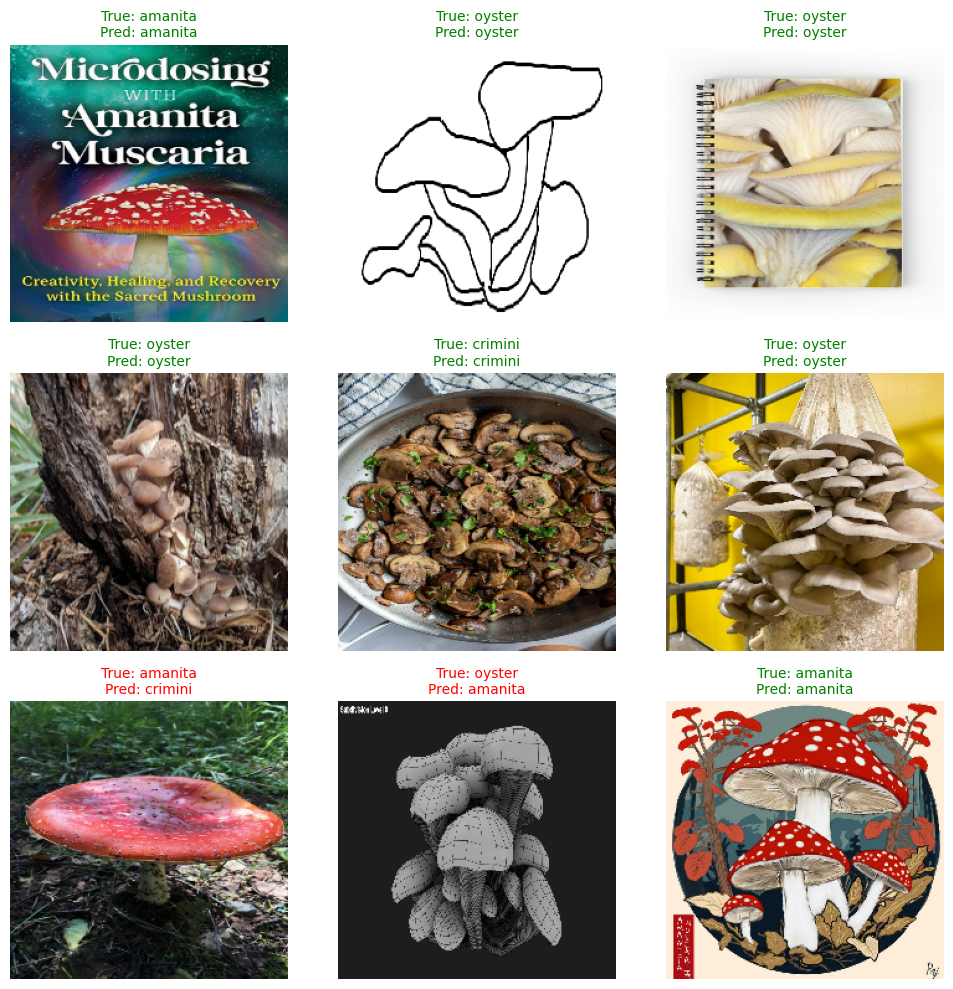

In [18]:
path = "tests"
test_dset_dir = pathlib.Path(path)

test_dset = tf.keras.utils.image_dataset_from_directory(
    test_dset_dir,
    shuffle=True,
    image_size=(img_height, img_width)
)

plot_images_grid_predicted_keras(test_dset, model, classes=class_names)

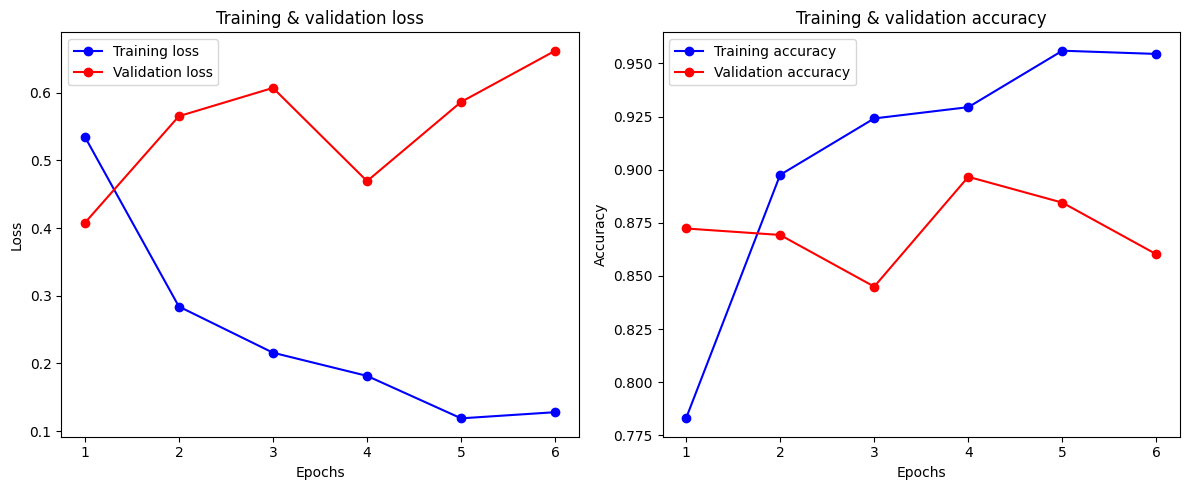

In [19]:
def plot_learning_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(1, len(loss) + 1)

    # Tracer la perte
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training & validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Tracer la précision
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
    plt.title('Training & validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_learning_curves(history)


### ``Keras Tuner``

Keras Tuner est une bibliothèque qui permet d'optimiser automatiquement les hyperparamètres d'un modèle de deep learning en testant différentes configurations de manière efficace.

L'optimisation des hyperparamètres peut améliorer :

   - La précision du modèle : trouver les meilleurs paramètres pour l'architecture du réseau
   -  Le temps d'entraînement : éviter de tester manuellement différentes combinaisons

In [20]:
data = []
for layer in model.layers:
    weights = layer.get_weights()
    if weights:
        for i, w in enumerate(weights):
            data.append({"Layer Name": layer.name, "Weight n°": i+1, "Shape": w.shape})

# Create a DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print(df)

# Optionally save to a CSV for further analysis
df.to_csv("model_weights.csv", index=False)

    Layer Name  Weight n°          Shape
0     resnet50          1  (7, 7, 3, 64)
1     resnet50          2          (64,)
2     resnet50          3          (64,)
3     resnet50          4          (64,)
4     resnet50          5          (64,)
..         ...        ...            ...
317   resnet50        318        (2048,)
318      dense          1    (2048, 128)
319      dense          2         (128,)
320    dense_1          1       (128, 3)
321    dense_1          2           (3,)

[322 rows x 3 columns]


In [21]:
def build_model(hp):
    data_augmentation = Sequential([
        RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width, 3)),
        RandomRotation(0.3),
        RandomZoom(0.2),
        RandomContrast(0.3)
    ])

    # Modèle EfficientNetB0 pré-entraîné
    efficientnet_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(img_height, img_width, 3))
    for layer in efficientnet_model.layers[:150]:
        layer.trainable = False

    # Construction du modèle
    model = Sequential([
        data_augmentation,
        efficientnet_model,
        GlobalAveragePooling2D(),
        Dense(
            hp.Int('units', min_value=64, max_value=256, step=64),
            activation=hp.Choice('activation', ['relu', 'tanh'])
        ),
        Dense(num_classes, activation="softmax")
    ])

    # Compilation du modèle
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# Instanciation de Keras Tuner avec RandomSearch
# = explore les combinaisons d'hyperparamètres de manière aléatoire
tuner = RandomSearch(
    build_model,
    # Maximiser la précision de validation
    objective='val_accuracy',
    # Nombre maximal de configurations testées
    max_trials=10,
     # Nombre d'exécutions par configuration
    executions_per_trial=1,
    # Stockage des résultats
    directory="keras_tuner_results"
)


Trial 10 Complete [00h 04m 35s]
val_accuracy: 0.936170220375061

Best val_accuracy So Far: 0.9422492384910583
Total elapsed time: 00h 44m 52s
Hyperparamètres trouvés :


KeyError: 'filters does not exist.'

In [26]:
checkpoint = ModelCheckpoint("Model(KerasTuner).h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto', save_freq="epoch")

tuner.search(train_dset, validation_data=val_dset, epochs=10)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

# Construire le modèle avec les meilleurs hyperparamètres trouvés
best_model = tuner.hypermodel.build(best_hps)

# Entraîner le modèle optimisé
history = best_model.fit(train_dset, validation_data=val_dset, callbacks=[checkpoint], epochs=20)


C:\Users\reynalde\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.6844 - loss: 0.7075
Epoch 1: val_accuracy improved from -inf to 0.89058, saving model to Model(KerasTuner).h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 39s 333ms/step - accuracy: 0.6858 - loss: 0.7050 - val_accuracy: 0.8906 - val_loss: 0.2741
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.8963 - loss: 0.2645
Epoch 2: val_accuracy improved from 0.89058 to 0.91185, saving model to Model(KerasTuner).h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 26s 316ms/step - accuracy: 0.8963 - loss: 0.2645 - val_accuracy: 0.9119 - val_loss: 0.2175
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.9305 - loss: 0.1932
Epoch 3: val_accuracy improved from 0.91185 to 0.91489, saving model to Model(KerasTuner).h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 26s 312ms/step - accuracy: 0.9305 - loss: 0.1931 - val_accuracy: 0.9149 - val_loss: 0.2120
Epoch 4/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.9766 - loss: 0.1031
Epoch 4: val_accuracy improved from 0.91489 to 0.92097, saving model to Model(KerasTuner).h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 26s 310ms/step - accuracy: 0.9765 - loss: 0.1031 - val_accuracy: 0.9210 - val_loss: 0.2033
Epoch 5/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.9726 - loss: 0.0943
Epoch 5: val_accuracy did not improve from 0.92097
83/83 ━━━━━━━━━━━━━━━━━━━━ 26s 309ms/step - accuracy: 0.9726 - loss: 0.0942 - val_accuracy: 0.9210 - val_loss: 0.2178
Epoch 6/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.9821 - loss: 0.0635
Epoch 6: val_accuracy did not improve from 0.92097
83/83 ━━━━━━━━━━━━━━━━━━━━ 26s 309ms/step - accuracy: 0.9821 - loss: 0.0635 - val_accuracy: 0.9210 - val_loss: 0.2192
Epoch 7/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.9888 - loss: 0.0469
Epoch 7: val_accuracy improved from 0.92097 to 0.92401, saving model to Model(KerasTuner).h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 26s 311ms/step - accuracy: 0.9887 - loss: 0.0470 - val_accuracy: 0.9240 - val_loss: 0.2487
Epoch 8/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.9897 - loss: 0.0326
Epoch 8: val_accuracy improved from 0.92401 to 0.92705, saving model to Model(KerasTuner).h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 26s 312ms/step - accuracy: 0.9897 - loss: 0.0326 - val_accuracy: 0.9271 - val_loss: 0.2491
Epoch 9/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.9910 - loss: 0.0271
Epoch 9: val_accuracy did not improve from 0.92705
83/83 ━━━━━━━━━━━━━━━━━━━━ 26s 310ms/step - accuracy: 0.9910 - loss: 0.0271 - val_accuracy: 0.9240 - val_loss: 0.2657
Epoch 10/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.9974 - loss: 0.0178
Epoch 10: val_accuracy improved from 0.92705 to 0.93009, saving model to Model(KerasTuner).h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 26s 315ms/step - accuracy: 0.9974 - loss: 0.0178 - val_accuracy: 0.9301 - val_loss: 0.2781
Epoch 11/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.9938 - loss: 0.0230
Epoch 11: val_accuracy did not improve from 0.93009
83/83 ━━━━━━━━━━━━━━━━━━━━ 26s 308ms/step - accuracy: 0.9938 - loss: 0.0230 - val_accuracy: 0.9301 - val_loss: 0.2508
Epoch 12/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.9923 - loss: 0.0205
Epoch 12: val_accuracy did not improve from 0.93009
83/83 ━━━━━━━━━━━━━━━━━━━━ 26s 309ms/step - accuracy: 0.9924 - loss: 0.0205 - val_accuracy: 0.9240 - val_loss: 0.2892
Epoch 13/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.9945 - loss: 0.0166
Epoch 13: val_accuracy did not improve from 0.93009
83/83 ━━━━━━━━━━━━━━━━━━━━ 26s 309ms/step - accuracy: 0.9945 - loss: 0.0167 - val_accuracy: 0.9149 - val_loss: 0.2959
Epoch 14/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.9989 - loss: 0.0152
Epoch 14: val_accuracy d

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.9412 - loss: 0.3929
Validation Accuracy: 0.94


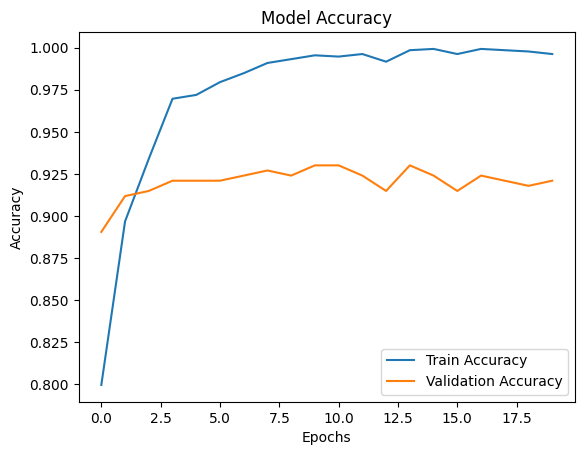

In [27]:
# Évaluation finale sur le jeu de validation
loss, accuracy = best_model.evaluate(test_dset)
print(f"Validation Accuracy: {accuracy:.2f}")

# Courbes de précision et de perte
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Found 17 files belonging to 3 classes.


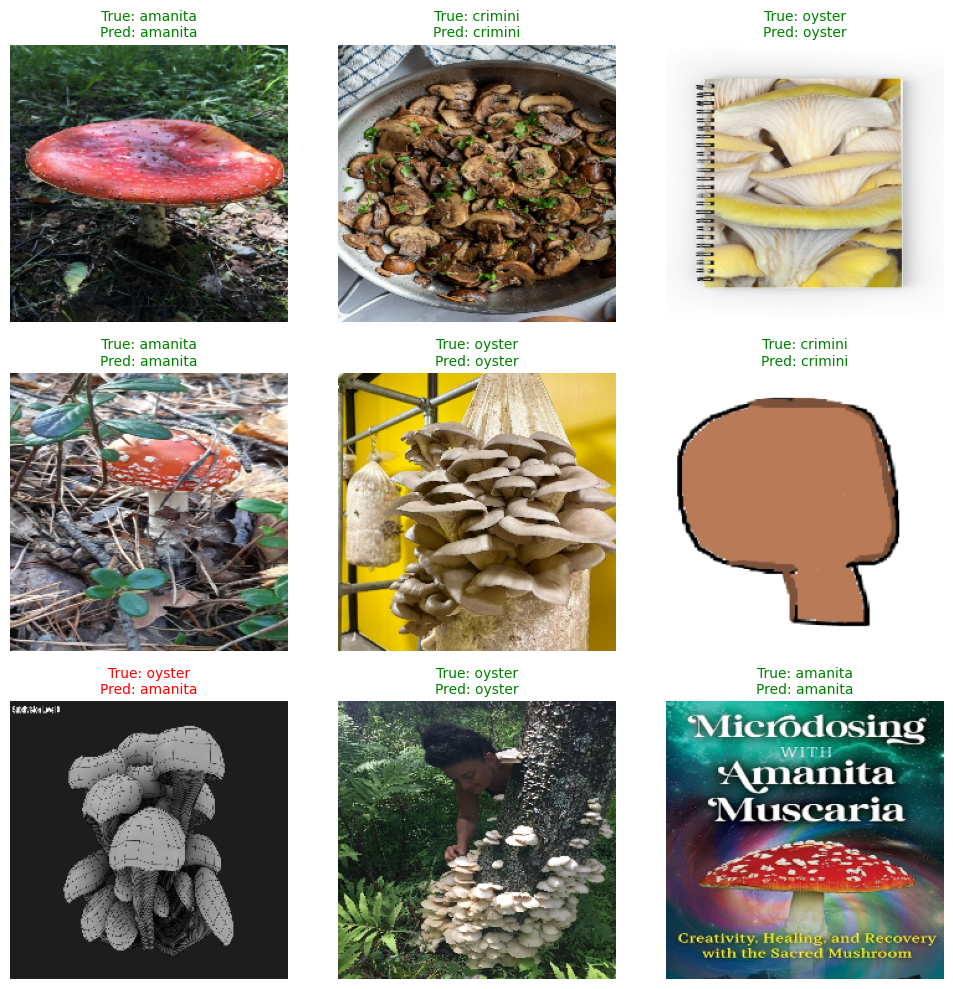

In [42]:
path = "tests"
test_dset_dir = pathlib.Path(path)

test_dset = tf.keras.utils.image_dataset_from_directory(
    test_dset_dir,
    shuffle=True,
    image_size=(img_height, img_width)
)

plot_images_grid_predicted_keras(test_dset, best_model, classes=class_names)

### ``DenseNet121``

In [30]:
densenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

for layer in densenet_model.layers:
    layer.trainable = False

model_densenet = Sequential([
    data_augmentation,
    densenet_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model_densenet.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [31]:
checkpoint = ModelCheckpoint("Model(DenseNet).h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

In [38]:
history = model_densenet.fit(
    train_dset,
    validation_data=val_dset,
    epochs=10,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.7497 - loss: 0.6502
Epoch 1: val_accuracy did not improve from 0.69605
83/83 ━━━━━━━━━━━━━━━━━━━━ 36s 440ms/step - accuracy: 0.7495 - loss: 0.6507 - val_accuracy: 0.6565 - val_loss: 0.8075 - learning_rate: 1.0000e-04
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.7191 - loss: 0.6934
Epoch 2: val_accuracy improved from 0.69605 to 0.70821, saving model to Model(DenseNet).h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 40s 478ms/step - accuracy: 0.7191 - loss: 0.6935 - val_accuracy: 0.7082 - val_loss: 0.7475 - learning_rate: 1.0000e-04
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.7338 - loss: 0.6736
Epoch 3: val_accuracy did not improve from 0.70821
83/83 ━━━━━━━━━━━━━━━━━━━━ 39s 474ms/step - accuracy: 0.7342 - loss: 0.6733 - val_accuracy: 0.6809 - val_loss: 0.8539 - learning_rate: 1.0000e-04
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.7412 - loss: 0.6078
Epoch 4: val_accuracy did not improve from 0.70821
83/83 ━━━━━━━━━━━━━━━━━━━━ 40s 479ms/step - accuracy: 0.7412 - loss: 0.6077 - val_accuracy: 0.6565 - val_loss: 0.8858 - learning_rate: 1.0000e-04
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.7334 - loss: 0.6572
Epoch 5: val_accuracy did not improve from 0.70821

Epoch 5: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
83/83 ━━━━━━━━━━━━━━━━━━━━ 40s 483ms/step - accuracy: 0.7333 - loss: 0.65

83/83 ━━━━━━━━━━━━━━━━━━━━ 41s 496ms/step - accuracy: 0.7697 - loss: 0.5344 - val_accuracy: 0.7143 - val_loss: 0.7380 - learning_rate: 4.0000e-06
Epoch 10/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.7831 - loss: 0.5139
Epoch 10: val_accuracy did not improve from 0.71429
83/83 ━━━━━━━━━━━━━━━━━━━━ 39s 475ms/step - accuracy: 0.7830 - loss: 0.5140 - val_accuracy: 0.7082 - val_loss: 0.7674 - learning_rate: 4.0000e-06


# Comparaison des modèles

In [ ]:
# ResNet50
resnet_results = model.evaluate(test_dset, verbose=0)
print(f"ResNet50 - Loss: {resnet_results[0]:.4f}, Accuracy: {resnet_results[1]*100:.2f}%")

# Modèle obtenu avec KerasTuner
kt_results = model.evaluate(test_dset, verbose=0)
print(f"ResNet50 - Loss: {kt_results[0]:.4f}, Accuracy: {kt_results[1]*100:.2f}%")

#  DenseNet121
densenet_results = model_densenet.evaluate(test_dset, verbose=0)
print(f"DenseNet121 - Loss: {densenet_results[0]:.4f}, Accuracy: {densenet_results[1]*100:.2f}%")


In [ ]:
models = ['ResNet50', 'KerasTuner', 'DenseNet121']
accuracies = [resnet_results[1] * 100, kt_results[1] * 100, densenet_results[1] * 100]
losses = [resnet_results[0], kt_results[0], densenet_results[0]]

# Précision
plt.bar(models, accuracies, color=['blue', 'green', 'red'])
plt.title('Comparaison des précisions des modèles')
plt.ylabel('Précision (%)')
plt.show()

# Perte
plt.bar(models, losses, color=['blue', 'green', 'red'])
plt.title('Comparaison des pertes des modèles')
plt.ylabel('Loss')
plt.show()
